## 数据集(仿真，801)
### 仿真数据集
```python
"""
For each timestep:
observations
    - images
        - each_cam_name     (480, 640, 3) 'uint8'
    - qpos                  (14,)         'float64'
    - qvel                  (14,)         'float64
action                      (14,)         'float64'
"""

# data_dict
data_dict = {
    '/observations/qpos': [],
    '/observations/qvel': [],
    '/action': [],
}

for cam_name in camera_names:
    data_dict[f'/observations/images/{cam_name}'] = []
    
rec_cam;
run_point;
rec_pid(rec_runPoint);
```

![Alt text](image.png)

![Alt text](image-2.png)


### 仿真代码  [record_sim_episodes.py](record_sim_episodes.py)
ATTENTION_HERE  
#dataset collect  
!python3 record_sim_episodes.py --task_name sim_transfer_cube_scripted --dataset_dir data2 --num_episodes 10 --onscreen_render 

1. ee_sim->joint_sim->dataset ts by ts->hdf5
2. run_code:images,qpos,qvel,action  
![Alt text](image-4.png)


### 训练[act_train](./imitate_episodes.py)
(这里给的是单任务模型，LLM可以选择具体使用哪个模型或者组合任务)
ATTENTION_HERE
1. K=100:'num_queries': args['chunk_size']
2. MODEL:[detr/models/detr_vae.py](./detr/models/detr_vae.py)
3. INPUT_OUTPUT:
    ```py
    # Embedding
        self.action_head = nn.Linear(hidden_dim, state_dim)
        self.input_proj_robot_state = nn.Linear(14, hidden_dim)
        self.encoder_action_proj = nn.Linear(14, hidden_dim) # project action to embedding
        self.encoder_joint_proj = nn.Linear(14, hidden_dim)  # project qpos to embedding
    ```



### 训练[act_train](./imitate_episodes.py)
4. sim_insertion_scripted --chunk_size 100 --hidden_dim 512 --batch_size 8 --dim_feedforward 3200 --num_epochs 500  --lr 1e-5 --seed 0->"time<1h"  
`Best ckpt, val loss 0.129679 @ epoch459`
![Alt text](train_val_loss_seed_0.png)

##### 输入元素(depth,target检测分割),单机械臂给7-13维度置0

### 训练[act_train](./imitate_episodes.py)
#### 收集单臂数据
#python3 record_sim_episodes.py --task_name sim_transfer_cube_scripted --dataset_dir data --num_episodes 10 --onscreen_render
  
#### 训练单臂数据    
#python3 imitate_episodes.py --task_name sim_transfer_cube_scripted --ckpt_dir /media/smj/新加卷1/dataset/ckpt_dir_7dim_7_14/ --policy_class ACT --kl_weight 10 --chunk_size 100 --hidden_dim 512 --batch_size 8 --dim_feedforward 3200 --num_epochs 500  --lr 1e-5 --seed 0  

#### 测试单臂模型   
python3 imitate_episodes.py --task_name sim_transfer_cube_scripted --ckpt_dir /media/smj/新加卷1/dataset/ckpt_dir_7dim_7_14/ --policy_class ACT --kl_weight 10 --chunk_size 100 --hidden_dim 512 --batch_size 8 --dim_feedforward 3200 --num_epochs 500  --lr 1e-5 --seed 0 --eval --temporal_agg --onscreen_render

#### Code_Modify:  
    # 收集数据的时候取后7维  

    # 训练的时候把相关的4个14置为7  
    
    # 测试的时候:  
        # imitate_episodes.py line184 取模型平均值的时候填充为初始值:np.array([0, -0.96, 1.16, 0, -0.3, 0, 0.02239],方差给一个很小很小的值  
        # imitate_episodes.py line235 因为训练的时候改了state_dim为7,但是双臂环境需要14,所以需要在设置一次14  
        # imitate_episodes.py line271 all_actions = policy(qpos[:, 7:14], curr_image),取张量的后7位,注意第一维度保留.不能是qpos[7:14]  
        # imitate_episodes.py line298 raw_action=np.concatenate((np.array([0, -0.96, 1.16, 0, -0.3, 0, 0.02239]),raw_action )),预测结果是7维,在双臂环境下加上左臂的静态位置

#### 预测结果 all_actions.shape=torch.Size([1, 100, 7]): 
![Alt text](image-6.png)

### script
![a](./visual/episode_0_qpos.png)

### human
![Alt text](episode_0_qpos.png)

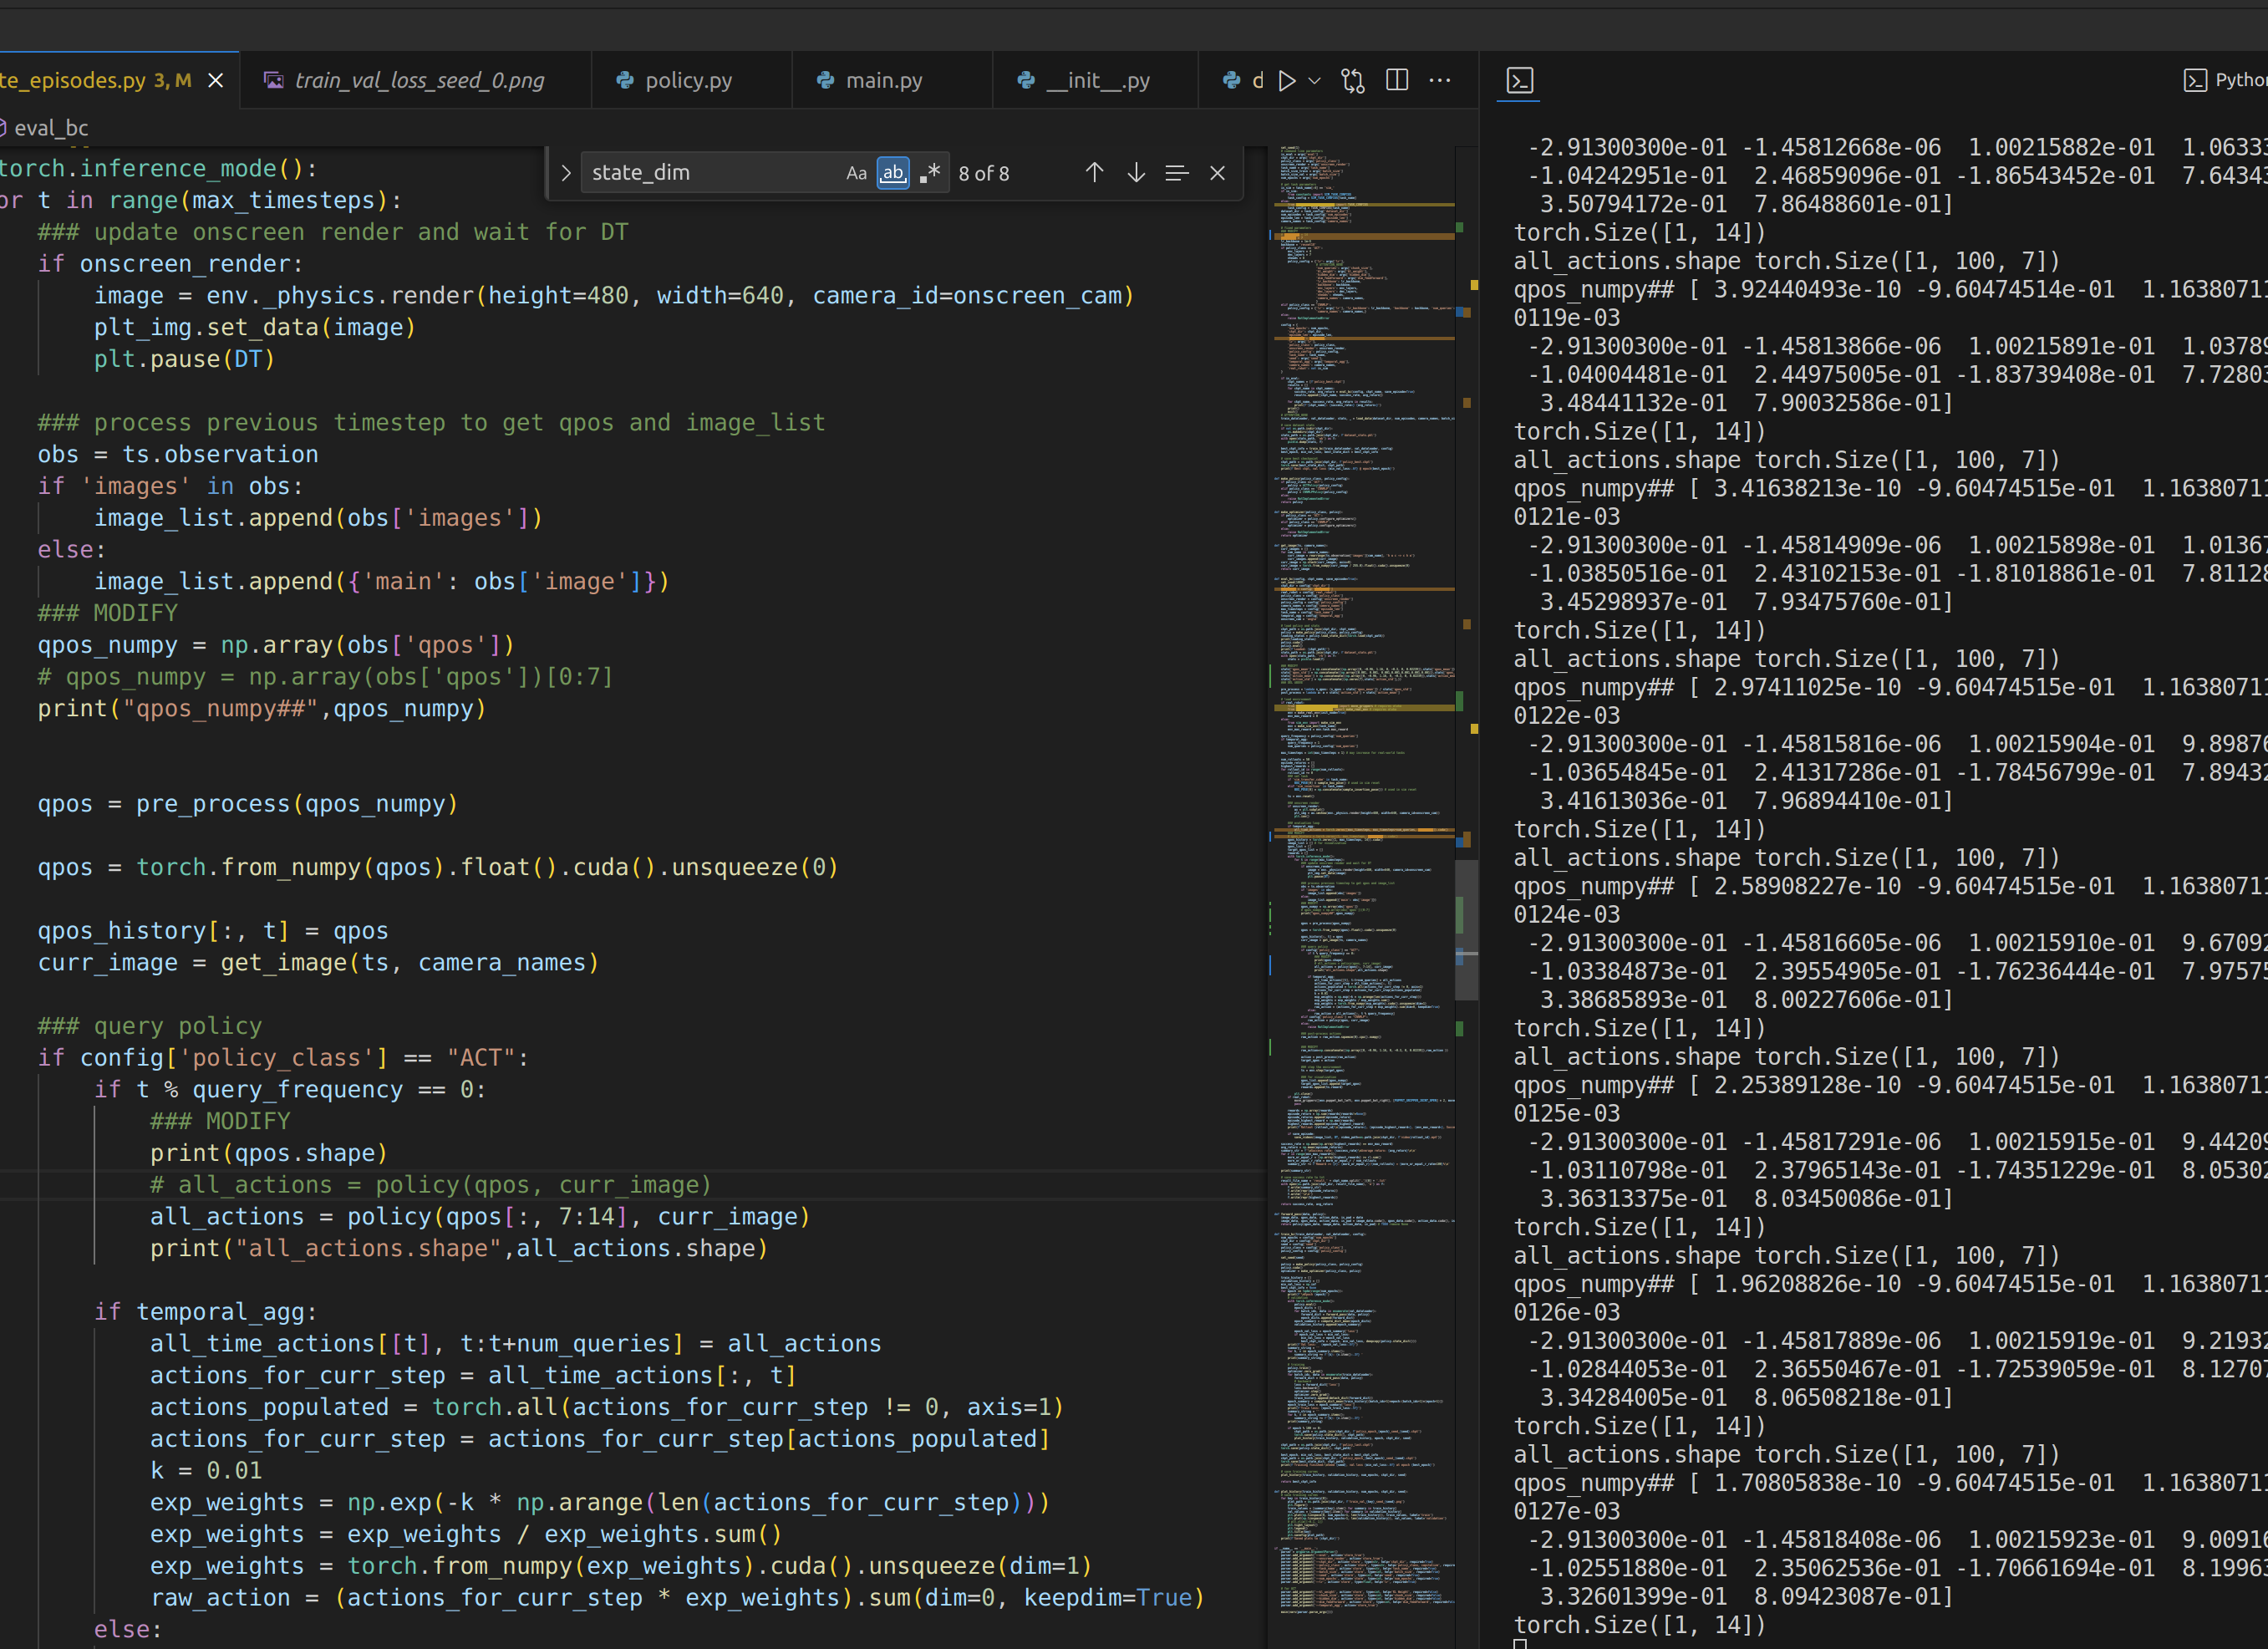

# rec:
## 收集单臂数据
#python3 record_sim_episodes.py --task_name sim_transfer_cube_scripted --dataset_dir data --num_episodes 10 --onscreen_render
  
## 训练单臂数据    
#python3 imitate_episodes.py --task_name sim_transfer_cube_scripted --ckpt_dir /media/smj/新加卷1/dataset/ckpt_dir_7dim_7_14/ --policy_class ACT --kl_weight 10 --chunk_size 100 --hidden_dim 512 --batch_size 8 --dim_feedforward 3200 --num_epochs 500  --lr 1e-5 --seed 0  

## 测试单臂模型   
python3 imitate_episodes.py --task_name sim_transfer_cube_scripted --ckpt_dir /media/smj/新加卷1/dataset/ckpt_dir_7dim_7_14/ --policy_class ACT --kl_weight 10 --chunk_size 100 --hidden_dim 512 --batch_size 8 --dim_feedforward 3200 --num_epochs 500  --lr 1e-5 --seed 0 --eval --temporal_agg --onscreen_render

# note:  
    # 收集数据的时候取后7维  

    # 训练的时候把相关的4个14置为7  
    
    # 测试的时候:  
        # imitate_episodes.py line184 取模型平均值的时候填充为初始值:np.array([0, -0.96, 1.16, 0, -0.3, 0, 0.02239],方差给一个很小很小的值  
        # imitate_episodes.py line235 因为训练的时候改了state_dim为7,但是双臂环境需要14,所以需要在设置一次14  
        # imitate_episodes.py line271 all_actions = policy(qpos[:, 7:14], curr_image),取张量的后7位,注意第一维度保留.不能是qpos[7:14]  
        # imitate_episodes.py line298 raw_action=np.concatenate((np.array([0, -0.96, 1.16, 0, -0.3, 0, 0.02239]),raw_action )),预测结果是7维,在双臂环境下加上左臂的静态位置
    


NOTE:
```bash
# cp,rm特定格式文件
find ./dataset -name "*.hdf5" -exec cp {} ./dataset/sim_insertion_human \;
find data/sim_transfer_cube_scripted/ -name "*.png" -exec rm {} \;
```
